<a href="https://colab.research.google.com/github/Kimjibeom/LSTM/blob/main/LSTM(imdb).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 신경망 훈련하기

IMDB 리뷰 데이터를 로드하고 훈련 세트와 검증 세트로 나눕니다.

In [3]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17473536/17464789 [==============================] - 0s 0us/step


케라스의 pad_sequences() 함수로 각 샘플의 길이를 100에 맞추고 부족할 때는 패딩을 추가합니다.

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

LSTM 셀을 사용한 순환층 생성

In [6]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500,16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

모델 구조 출력

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


LSTM 모델 파라미터 개수는 800개
모델을 컴파일하고 훈련
- 배치 크기 : 64개
- 에포크 횟수 : 100

체크포인트와 조기 종료를 위한 코드

In [9]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size= 64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 47ms/step - loss: 0.6926 - accuracy: 0.5254 - val_loss: 0.6920 - val_accuracy: 0.5362
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6904 - accuracy: 0.5914 - val_loss: 0.6890 - val_accuracy: 0.6136
Epoch 3/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6855 - accuracy: 0.6325 - val_loss: 0.6818 - val_accuracy: 0.6512
Epoch 4/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6729 - accuracy: 0.6707 - val_loss: 0.6609 - val_accuracy: 0.6828
Epoch 5/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6180 - accuracy: 0.7137 - val_loss: 0.5731 - val_accuracy: 0.7206
Epoch 6/100
313/313 [==============================] - 14s 45ms/step - loss: 0.5530 - accuracy: 0.7373 - val_loss: 0.5453 - val_accuracy: 0.7436
Epoch 7/100
313/313 [==============================] - 14s 45ms/step - loss: 0.5292 - accuracy: 0.7569 - val_loss: 0.5251 - val_ac

# 훈련 손실과 검증 손실 그래프

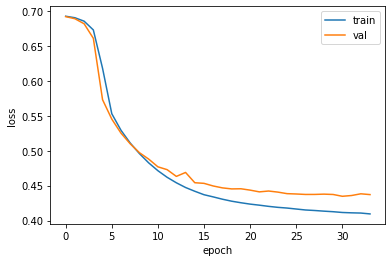

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

과대적합을 억제하고 있지만 더 강하게 제어할 필요가 있음.

# 순환층에 드롭아웃 적용하기

순환층은 자체적으로 드롭아웃 기능을 제공한다. 

드롭아웃 -> 은닉층에 있는 뉴런의 출력을 랜던하게 꺼서 과대적합을 막는 기법입니다.


dropout 매개변수는 셀의 입력에 드롭아웃을 적용

recurrent_dropout은 순환되는 은닉 상태에 드롭아웃을 적용


하지만 기술적인 문제로 인해 recurrent_dropout을 사용하면 GPU를 사용하여 모델을 훈련하지 못한다. => 모델의 훈련 속도가 크게 느려짐

따라서 여기서는 dropout만을 사용하여 구현

In [10]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size= 64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 48ms/step - loss: 0.6926 - accuracy: 0.5351 - val_loss: 0.6919 - val_accuracy: 0.5882
Epoch 2/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6905 - accuracy: 0.6112 - val_loss: 0.6887 - val_accuracy: 0.6508
Epoch 3/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6831 - accuracy: 0.6610 - val_loss: 0.6727 - val_accuracy: 0.6856
Epoch 4/100
313/313 [==============================] - 15s 46ms/step - loss: 0.6401 - accuracy: 0.6942 - val_loss: 0.6150 - val_accuracy: 0.6946
Epoch 5/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6061 - accuracy: 0.7063 - val_loss: 0.5956 - val_accuracy: 0.7180
Epoch 6/100
313/313 [==============================] - 14s 46ms/step - loss: 0.5892 - accuracy: 0.7211 - val_loss: 0.5783 - val_accuracy: 0.7286
Epoch 7/100
313/313 [==============================] - 15s 46ms/step - loss: 0.5723 - accuracy: 0.7355 - val_loss: 0.5654 - val_ac

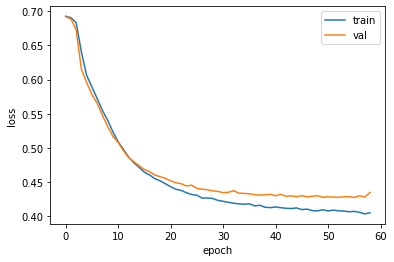

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()